In [74]:
import PIL
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision

# images are in ./data/train
# dog images begin with 'dog'
# cat images begin with 'cat'

cat_image_names=[]
dog_image_names=[]
for file in os.listdir('./data/train'):
    if file.startswith('cat'):
        cat_image_names.append(file)
    else:
        dog_image_names.append(file)

In [75]:
def load_batch_of_images(image_names):
    images=[]
    for image_name in image_names:
        images.append(PIL.Image.open('./data/train/'+image_name))
    return images

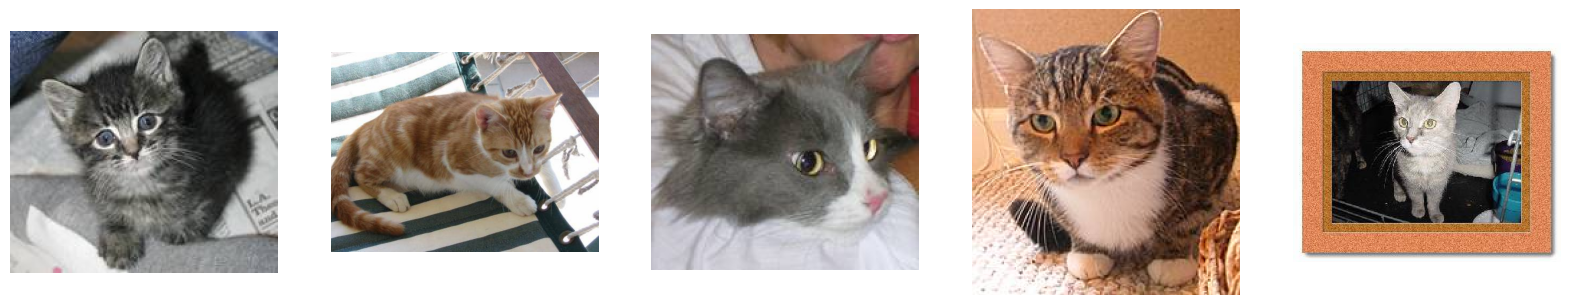

In [76]:
# plot first five cat images
cat_images=load_batch_of_images(cat_image_names[:5])
fig, ax=plt.subplots(1, len(cat_images), figsize=(20, 20))
for i in range(len(cat_images)):
    ax[i].imshow(cat_images[i])
    ax[i].axis('off')
plt.show()

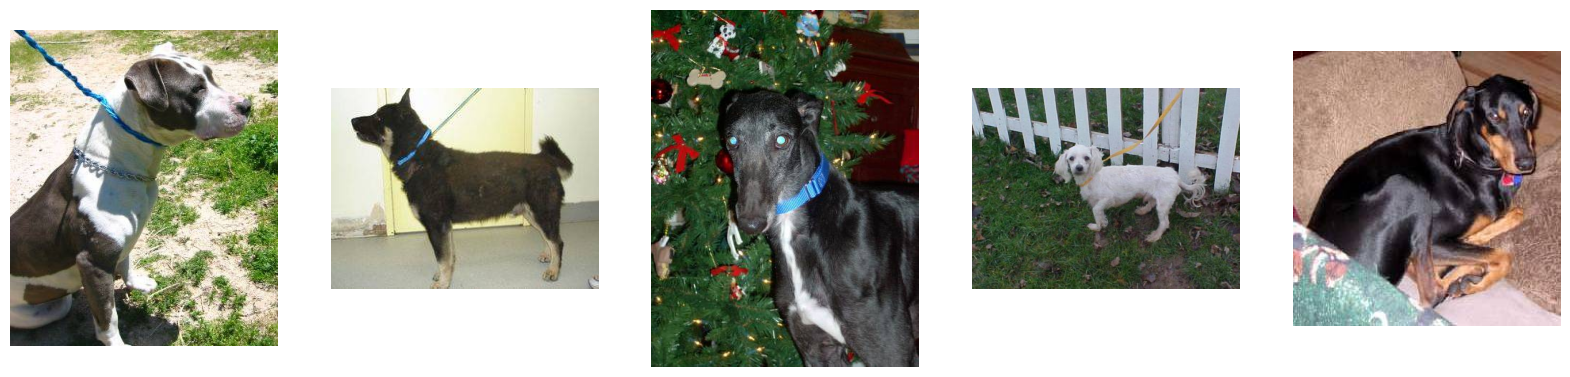

In [77]:
# plot first five dog images
dog_images=load_batch_of_images(dog_image_names[:5])
fig, ax=plt.subplots(1, len(dog_images), figsize=(20, 20))
for i in range(len(dog_images)):
    ax[i].imshow(dog_images[i])
    ax[i].axis('off')
plt.show()

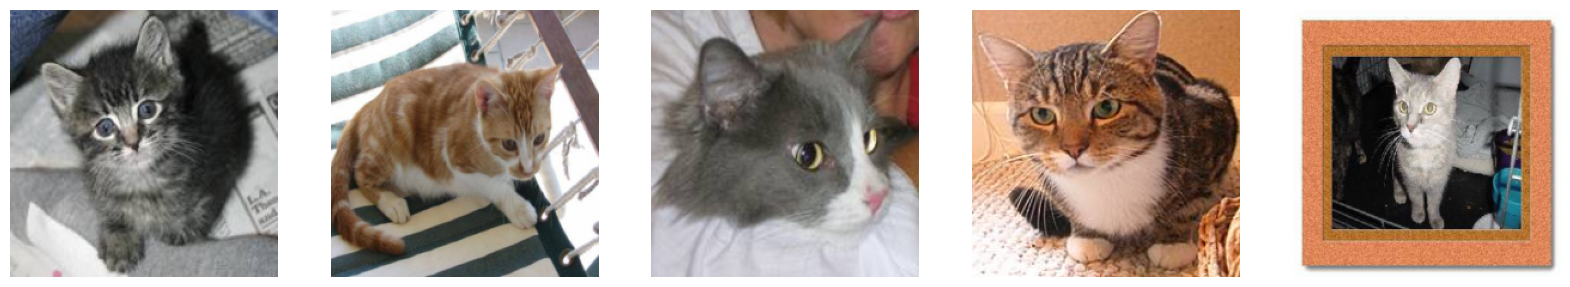

In [78]:
# make all images the same size
# resize to 224x224
# convert to tensor
# add batch dimension

from torchvision import transforms

transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ])

cat_images=load_batch_of_images(cat_image_names[:5])

cat_images_tensor=torch.stack([transform(image) for image in cat_images])

# plot first five cat images
fig, ax=plt.subplots(1, len(cat_images_tensor), figsize=(20, 20))
for i in range(len(cat_images_tensor)):
    ax[i].imshow(cat_images_tensor[i].permute(1, 2, 0))
    ax[i].axis('off')
plt.show()

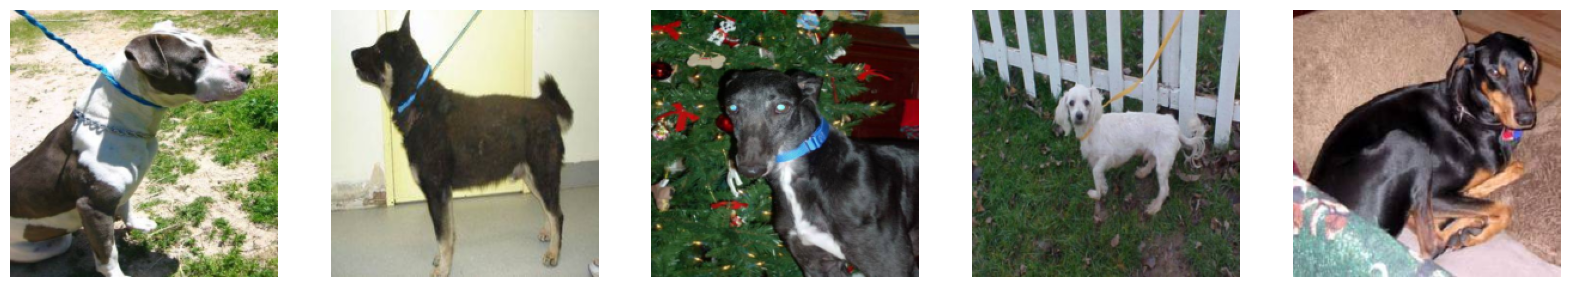

In [79]:
dog_images=load_batch_of_images(dog_image_names[:5])

dog_images_tensor=torch.stack([transform(image) for image in dog_images])

# plot first five dog images
fig, ax=plt.subplots(1, len(dog_images_tensor), figsize=(20, 20))
for i in range(len(dog_images_tensor)):
    ax[i].imshow(dog_images_tensor[i].permute(1, 2, 0))
    ax[i].axis('off')

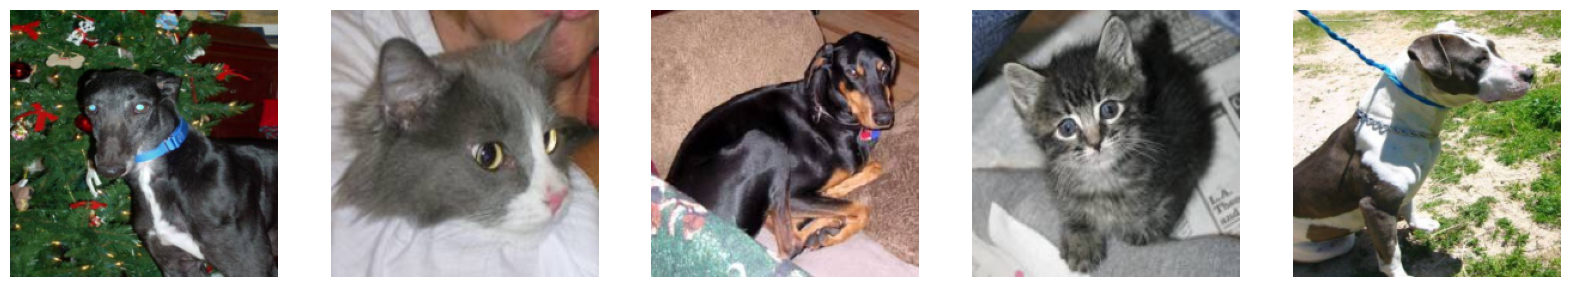

In [80]:
# combine cat and dog images
images_tensor=torch.cat([cat_images_tensor, dog_images_tensor], dim=0)

# create labels
# 0 for cat
# 1 for dog
labels_tensor=torch.cat([torch.zeros(len(cat_images_tensor)), torch.ones(len(dog_images_tensor))], dim=0)

# create dataset
dataset=torch.utils.data.TensorDataset(images_tensor, labels_tensor)

# create dataloader
dataloader=torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

# plot first batch of images
images, labels=next(iter(dataloader))
fig, ax=plt.subplots(1, len(images), figsize=(20, 20))
for i in range(len(images)):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].axis('off')
plt.show()

In [81]:
from sklearn.model_selection import train_test_split

# create x and y
x=images_tensor
y=labels_tensor

# split into train and test
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.float()
x_test = x_test.float()
y_train = y_train.long()
y_test = y_test.long()


In [82]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

    # Konstruktor
    def __init__(self):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten

        # Convolutional Layer
        # die erste 3 bedeutet, dass wir 3 Farbkanäle haben
        # die 32 bedeutet, dass wir 32 Filter verwenden
        # die letzte 3 bedeutet, dass wir 3x3 Filter verwenden
        self.conv1 = torch.nn.Conv2d(3, 32, 3)

        # 32: 32 Features gehen rein
        # 64: 64 Features gehen raus
        # 3: Filtergräße 3x3
        # padding 1: Außen um das Bild eine Reihen mit Nullen
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1, stride=2)


        # stride 2: springe mit dem Filter immer zwei Felder weiter (default 1)
        self.conv3 = torch.nn.Conv2d(64, 212, 3, padding=1, stride=2)

        self.fc = torch.nn.Linear(664832, 10)

        self.bn1 = torch.nn.BatchNorm1d(664832)

    # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)  # ---> 3x32x32

        xb = self.conv1(xb)
        #print("conv1", xb.shape)   # ---> 32x30x30
        xb = torch.nn.functional.relu(xb)

        xb = self.conv2(xb)
        #print("conv2", xb.shape)  # ---> 64x15x15
        xb = torch.nn.functional.relu(xb)

        xb = self.conv3(xb)
        #print("conv3", xb.shape)  # ---> 212x8x8
        xb = torch.nn.functional.relu(xb)

        # flatten
        xb = xb.view(xb.size(0), -1)
        #print("flatten", xb.shape)
        xb = self.bn1(xb)
        xb = self.fc(xb)
        xb = torch.nn.functional.relu(xb)
        return xb

In [83]:
def get_batch(x, y, batch_size):
    # z.B. range(0, 10, 3) --> 0, 3, 6, 9
    # range(start, stop, step)
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

def get_accuracy(x, y):
    preds = model(x)
    preds = torch.argmax(preds, dim=1)
    correct=sum(preds == y)
    return correct.item()/len(x)

model = MySimpleNN()
xb, yb = next(get_batch(x_train, y_train, 64))
model(xb).shape

torch.Size([8, 10])

In [84]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cpu


In [85]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [86]:

# eigenes Modell wird erstellt
model = MySimpleNN().to(device)
lr=0.01
# trainiere immer mit 10 Datensätzen auf einmal
batch_size=128

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    with torch.no_grad():
        # Iteration über alle Parameter im Modell
        for param in model.parameters():
            # Backpropagation, d.h. die Veränderung der Gewichte in Abhängigkeit der Ableitung
            param -= lr * param.grad
        # Alle Gradients im Modell werden auf 0 gesetzt
        model.zero_grad()
    return loss.item()

losses=[]
valid_accuracies=[]
batch_count=len(x_train)//batch_size
# import tqdm notebook
from tqdm.notebook import tqdm
for epoch in tqdm(range(100)):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(x_train, y_train, batch_size):
        loss_sum+=train(xb, yb)
    losses.append(loss_sum/batch_count)
    valid_accuracies.append(get_accuracy(x_test, y_test))

ModuleNotFoundError: No module named 'tqdm'

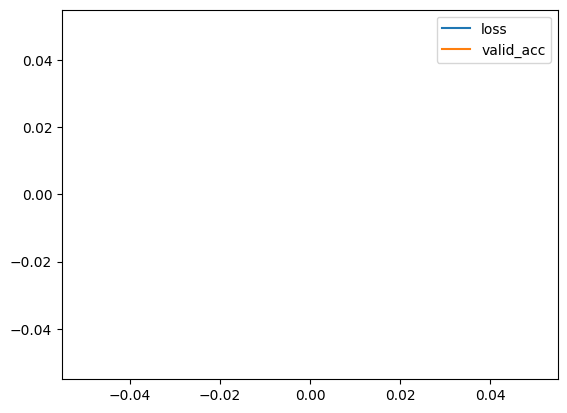

In [88]:
plt.plot(losses, label="loss")
plt.plot(valid_accuracies, label="valid_acc")
plt.legend()